In [1]:
import os
import sys
import warnings
import logging

module_path = os.path.abspath('../src')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.baseline_model import BaselineModel
from models.linear_model import LinearModel
from models.prophet_model import ProphetModel
from models.xgb_model import XGBModel
from models.lgb_model import LGBModel
from models.sarimax_model import SarimaxModel
from models.ensemble_model import EnsembleModel
from utils.preprocessor import Preprocessor
from utils.model_selection import back_test, grid_search

warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.WARNING)

%matplotlib inline
%load_ext autoreload
%autoreload

Percentage of outlier: 3.78683241252302%


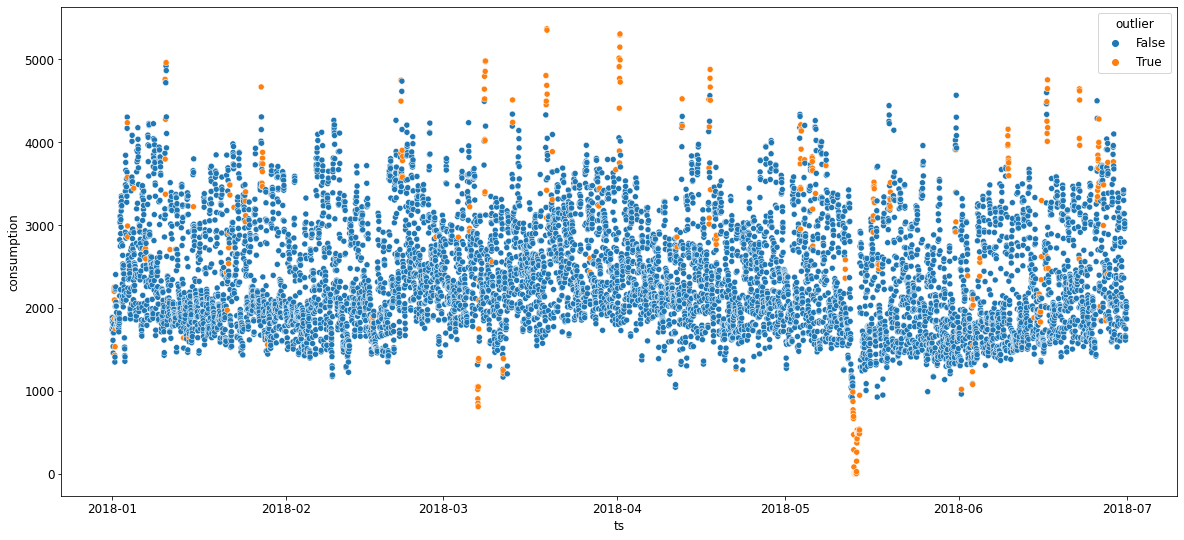

In [2]:
df_raw_scm = pd.read_csv('../data/scm_july16_feb20.csv', parse_dates=True, index_col='timestamp')
df_scm = df_raw_scm.loc['2018-01':'2018-06'].copy()
pp = Preprocessor(resample_freq='30min', na_th='2h', agg='mean')
df_scm_pp = pp.fit(df_scm).transform(df_scm)

Test Sarimax Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66551D+00    |proj g|=  1.05960D-01


 This problem is unconstrained.



At iterate    5    f=  6.60869D+00    |proj g|=  1.08519D-02

At iterate   10    f=  6.60263D+00    |proj g|=  9.37364D-04

At iterate   15    f=  6.59298D+00    |proj g|=  2.14389D-04

At iterate   20    f=  6.59211D+00    |proj g|=  1.80319D-02

At iterate   25    f=  6.59103D+00    |proj g|=  5.62395D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     25     46      1     0     0   5.624D-07   6.591D+00
  F =   6.5910326908156485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


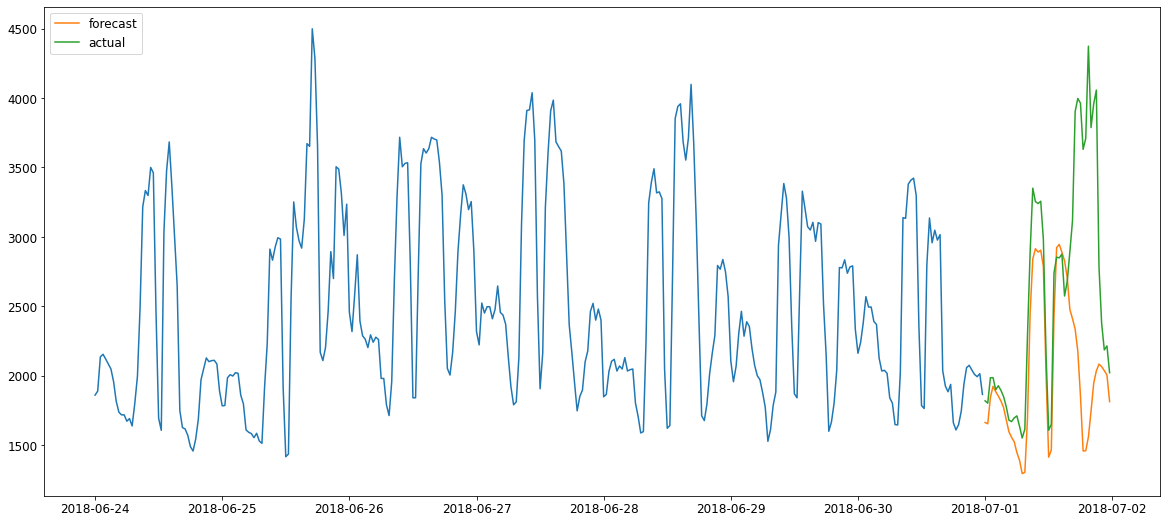

In [3]:
sarimax = SarimaxModel(freq='30min', horizon='1d')
res = sarimax.fit(df_scm_pp).predict(df_scm_pp)
plt.figure(figsize=(20,9))
plt.plot(df_scm_pp.iloc[-48*7:].index, df_scm_pp.iloc[-48*7:].values)
plt.plot(res.index, res.values, label='forecast')
plt.plot(df_raw_scm['2018-07-01'].index, df_raw_scm['2018-07-01'].values, label='actual')
plt.legend()

Test Ensemble Model

=====Linear model training completed=====


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66568D+00    |proj g|=  1.05981D-01

At iterate    5    f=  6.60885D+00    |proj g|=  1.08564D-02

At iterate   10    f=  6.60279D+00    |proj g|=  9.37261D-04

At iterate   15    f=  6.59313D+00    |proj g|=  2.15297D-04

At iterate   20    f=  6.59226D+00    |proj g|=  1.80537D-02

At iterate   25    f=  6.59119D+00    |proj g|=  5.41966D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     46      1     0     0   

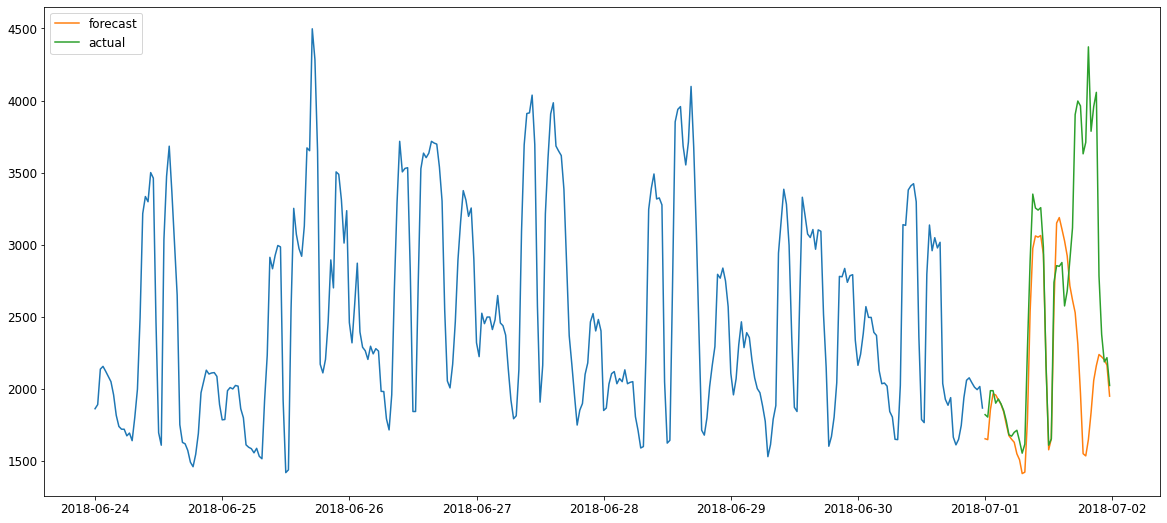

In [4]:
ensemble = EnsembleModel(freq='30min', horizon='1d', models=['Linear', 'Sarimax'], ensemble_method='median')
res_ensemble = ensemble.fit(df_scm_pp).predict(df_scm_pp)

plt.figure(figsize=(20,9))
plt.plot(df_scm_pp.iloc[-48*7:].index, df_scm_pp.iloc[-48*7:].values)
plt.plot(res_ensemble.index, res_ensemble.values, label='forecast')
plt.plot(df_raw_scm['2018-07-01'].index, df_raw_scm['2018-07-01'].values, label='actual')
plt.legend()

Test Backtesting

In [5]:
baseline = BaselineModel(freq='30min', horizon='1d')
lasso = LinearModel(freq='30min', horizon='1d')
prophet = ProphetModel(freq='30min', horizon='1d')
lgb = LGBModel(freq='30min', horizon='1d')
xgb = XGBModel(freq='30min', horizon='1d')
sarimax = SarimaxModel(freq='30min', horizon='1d')

res = []
for f in [baseline, lasso, prophet, lgb, xgb, sarimax]:
    res_temp = back_test(f, df_scm_pp, test_size=0.05, stride='1d', retrain_stride=False)
    res_temp['model'] = f.name
    res.append(res_temp)
    print(f'===={f.name} model completed====')

pd.DataFrame(res).set_index('model')

====Baseline model completed====
====Linear model completed====
Initial log joint probability = -106.322
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16466.9     0.0249843       1298.34       0.443           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16484.5    0.00191149       605.458           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16490.2    0.00212247       110.284           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       16491.4    9.0671e-05       170.249   3.035e-07       0.001      441  LS failed, Hessian reset 
     399       16492.3   3.47186e-05       59.0625           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65972D+00    |proj g|=  1.08153D-01

At iterate    5    f=  6.60106D+00    |proj g|=  1.02518D-02

At iterate   10    f=  6.59507D+00    |proj g|=  9.49344D-04

At iterate   15    f=  6.58502D+00    |proj g|=  5.96502D-05

At iterate   20    f=  6.58377D+00    |proj g|=  8.22998D-03

At iterate   25    f=  6.58324D+00    |proj g|=  3.97398D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     25     34      1     0     0   

,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
model,,,,,,,,
Baseline,418.986020,183817.848223,301.275388,0.120524,96.447571,86617.045155,83.485871,0.026623
Linear,345.657547,127422.599598,244.447029,0.099085,94.532493,77377.166341,65.133747,0.020427
Prophet,441.965982,204916.632997,335.671712,0.128019,103.829386,92776.774570,86.539492,0.019799
LGB,335.437680,122823.121090,249.523666,0.096751,107.669722,78028.164853,78.054593,0.021439
XGB,349.706922,127971.406290,253.809227,0.101000,79.912668,66149.349176,51.478850,0.011787
Sarimax,386.777741,156391.121951,287.002540,0.117086,87.426333,72969.023722,73.941420,0.029086


Test Grid Search

In [6]:
sarimax = SarimaxModel(freq='30min', horizon='1d')
params = {
    'p': [0, 1],
    'd': [0, 1],
    'q': [0, 1],
    'seasonal_p': [1],
    'seasonal_d': [1],
    'seasonal_q': [1],
    'cyclic_feature_encoding': ['sincos']
}
grid_search(sarimax, params, df_scm_pp, test_size=0.05, stride='1d', retrain_stride=False)

  0%|          | 0/8 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42379D+00    |proj g|=  1.21542D-01


 This problem is unconstrained.



At iterate    5    f=  7.34910D+00    |proj g|=  2.66914D-02

At iterate   10    f=  7.33859D+00    |proj g|=  4.64163D-04

At iterate   15    f=  7.33742D+00    |proj g|=  3.99443D-03

At iterate   20    f=  7.32825D+00    |proj g|=  5.77360D-03

At iterate   25    f=  7.32573D+00    |proj g|=  1.59072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   1.591D-05   7.326D+00
  F =   7.3257299106410247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 12%|█▎        | 1/8 [06:01<42:13, 362.00s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42271D+00    |proj g|=  8.82022D-01

At iterate    5    f=  7.10811D+00    |proj g|=  1.74283D-02

At iterate   10    f=  7.09987D+00    |proj g|=  1.56452D-03

At iterate   15    f=  7.03036D+00    |proj g|=  3.31826D-01

At iterate   20    f=  6.92753D+00    |proj g|=  3.30805D-03

At iterate   25    f=  6.92751D+00    |proj g|=  1.45862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     27      1     0     0   

 25%|██▌       | 2/8 [12:24<37:25, 374.29s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65984D+00    |proj g|=  1.08151D-01


 This problem is unconstrained.



At iterate    5    f=  6.60120D+00    |proj g|=  1.02602D-02

At iterate   10    f=  6.59521D+00    |proj g|=  9.49119D-04

At iterate   15    f=  6.58516D+00    |proj g|=  6.12834D-05

At iterate   20    f=  6.58391D+00    |proj g|=  9.32039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     34      1     0     0   9.874D-06   6.583D+00
  F =   6.5833737435771393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 38%|███▊      | 3/8 [27:07<50:32, 606.58s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69371D+00    |proj g|=  7.61797D-02


 This problem is unconstrained.



At iterate    5    f=  6.65351D+00    |proj g|=  2.46728D-02

At iterate   10    f=  6.64598D+00    |proj g|=  8.39916D-03

At iterate   15    f=  6.57935D+00    |proj g|=  4.72521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     21      1     0     0   9.995D-06   6.579D+00
  F =   6.5793348571055006     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 50%|█████     | 4/8 [32:26<32:52, 493.02s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71219D+00    |proj g|=  7.27953D-02

At iterate    5    f=  6.63344D+00    |proj g|=  1.31792D-02

At iterate   10    f=  6.62724D+00    |proj g|=  1.77293D-03

At iterate   15    f=  6.56126D+00    |proj g|=  2.76706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     24      1     0     0   1.435D-05   6.561D+00
  F =   6.5611309656781129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 62%|██████▎   | 5/8 [38:00<21:46, 435.38s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69850D+00    |proj g|=  7.48437D-02

At iterate    5    f=  6.61975D+00    |proj g|=  9.95695D-03

At iterate   10    f=  6.61535D+00    |proj g|=  3.74937D-03

At iterate   15    f=  6.61361D+00    |proj g|=  1.75843D-02

At iterate   20    f=  6.54866D+00    |proj g|=  4.18599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     24     29      1     0     0   1.586D-05   6.549D+00
  F =   6.5486415229760038     

CONVERG

 75%|███████▌  | 6/8 [45:18<14:32, 436.49s/it] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69478D+00    |proj g|=  7.62697D-02

At iterate    5    f=  6.65552D+00    |proj g|=  1.58333D-02

At iterate   10    f=  6.65059D+00    |proj g|=  1.75262D-03

At iterate   15    f=  6.58095D+00    |proj g|=  2.23026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     22      1     0     0   4.531D-06   6.581D+00
  F =   6.5809451003435546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 88%|████████▊ | 7/8 [50:31<06:35, 395.93s/it]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69374D+00    |proj g|=  7.61845D-02


 This problem is unconstrained.



At iterate    5    f=  6.65460D+00    |proj g|=  3.91350D-02

At iterate   10    f=  6.64963D+00    |proj g|=  7.65152D-03

At iterate   15    f=  6.63045D+00    |proj g|=  7.18625D-02

At iterate   20    f=  6.58550D+00    |proj g|=  1.15815D-01

At iterate   25    f=  6.58443D+00    |proj g|=  5.66072D-04

At iterate   30    f=  6.58437D+00    |proj g|=  9.67420D-03

At iterate   35    f=  6.58222D+00    |proj g|=  2.34937D-02

At iterate   40    f=  6.58216D+00    |proj g|=  2.67041D-04

At iterate   45    f=  6.58213D+00    |proj g|=  9.98134D-03

At iterate   50    f=  6.58133D+00    |proj g|=  4.76359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

100%|██████████| 8/8 [1:07:30<00:00, 506.35s/it]


,parameter,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std,model
0,"{'p': 0, 'd': 0, 'q': 0, 'seasonal_p': 1, 'sea...",435.818150,200583.248138,329.715548,0.126258,109.437249,102167.412213,87.793120,0.023467,Sarimax
1,"{'p': 0, 'd': 0, 'q': 1, 'seasonal_p': 1, 'sea...",376.504601,150833.085339,272.298398,0.106996,101.054648,87407.230762,81.356218,0.023838,Sarimax
2,"{'p': 0, 'd': 1, 'q': 0, 'seasonal_p': 1, 'sea...",386.835026,156719.800021,286.651618,0.116295,89.237158,74446.549213,76.321644,0.028116,Sarimax
3,"{'p': 0, 'd': 1, 'q': 1, 'seasonal_p': 1, 'sea...",386.584076,156792.175314,287.423434,0.116923,90.901283,75351.810355,76.585511,0.028849,Sarimax
4,"{'p': 1, 'd': 0, 'q': 0, 'seasonal_p': 1, 'sea...",376.654951,149962.903756,275.289885,0.108897,95.423767,80642.638818,77.656252,0.021988,Sarimax
5,"{'p': 1, 'd': 0, 'q': 1, 'seasonal_p': 1, 'sea...",377.298100,150390.909203,275.911807,0.109145,95.087772,80359.775197,77.343726,0.021768,Sarimax
6,"{'p': 1, 'd': 1, 'q': 0, 'seasonal_p': 1, 'sea...",386.308727,156579.407834,287.238587,0.116935,90.901580,75331.201435,76.536536,0.029052,Sarimax
7,"{'p': 1, 'd': 1, 'q': 1, 'seasonal_p': 1, 'sea...",386.491694,156482.625920,286.372607,0.116251,89.415580,74611.795938,76.421862,0.028414,Sarimax


Test Automated Forecasting (Bayesian)

In [7]:
from forecaster import AutomatedForecasting
af = AutomatedForecasting(models=['Sarimax'], method='bayesian', iteration=1)
af.fit(df_scm_pp)

Sarimax                                              
{'cyclic_feature_encoding': 'onehot', 'd': 0.0, 'p': 1.0, 'q': 0.0, 'seasonal_d': 0.0, 'seasonal_p': 0.0, 'seasonal_q': 1.0}
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88477D+00    |proj g|=  5.06480D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35      1     21      1     0     0   5.065D+00   6.885D+00
  F =   6.8847681662140561     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


100%|██████████| 1/1 [11:22<00:00, 682.29s/trial, best loss: 465.3491541026126]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91012D+00    |proj g|=  9.33645D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35      1     21      1     0     0   9.336D+00   6.910D+00
  F =   6.9101159540831736     

ABNORMAL_TERMINATION_IN_LNSRCH                              
===training completed===
best_model:  {'model': 'Sarimax', 'cyclic_feature_encoding': 'onehot', 'd': 0, 'p': 1, 'q': 0, 'seasonal_d': 0, 'seasonal_p': 0, 'seasonal_q': 1}


AutomatedForecasting(iteration=1, models=['Sarimax'])

Test Automated Forecasting (Randomized Search)

In [8]:
from forecaster import AutomatedForecasting
af = AutomatedForecasting(models=['Sarimax'], method='randomized_search', iteration=1)
af.fit(df_scm_pp)

Sarimax


  0%|          | 0/1 [00:00<?, ?it/s]

{'cyclic_feature_encoding': 'onehot', 'd': 0, 'p': 0, 'q': 0, 'seasonal_d': 0, 'seasonal_p': 0, 'seasonal_q': 0}
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14145D+01    |proj g|=  5.16766D-03


 This problem is unconstrained.
  ascent direction in projection gd =    6.2107694407974791E-002

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33      3     40      2     0     0   3.717D+01   7.492D+00
  F =   7.4919784218357348     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
100%|██████████| 1/1 [00:14<00:00, 14.08s/it]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15457D+01    |proj g|=  7.57672D-03


 This problem is unconstrained.
  ascent direction in projection gd =    1.3694461596577397E-002

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33      3     39      2     0     0   6.704D+01   7.511D+00
  F =   7.5113697927841212     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


===training completed===
best_model:  {'model': 'Sarimax', 'cyclic_feature_encoding': 'onehot', 'd': 0, 'p': 0, 'q': 0, 'seasonal_d': 0, 'seasonal_p': 0, 'seasonal_q': 0}


AutomatedForecasting(iteration=1, method='randomized_search',
                     models=['Sarimax'])